# Resnet 20 - CIFAR10

## Comparing multiple executions

* How stable is the ranking of discovered networks?
 

Let's run 4 instances of AMC (ResNet20, DDPG) and then review the results.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib 
import csv
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from matplotlib import animation, rc

from auto_compression_jupyter import *

#plt.style.use('seaborn') # pretty matplotlib plots

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

    
# Widen the cells to get entire rows in the screen.
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

EXPERIMENTS_DIR = "/home/young/liuyixin/CAMC_disllter/experiments"

In [3]:
fpath = os.path.join(EXPERIMENTS_DIR, "resnet20-ddpg-private", "2020.09.15-193705")
df_list = load_experiment_instances(fpath)

## Multiple experiment runs

Below we plot the execution of the same experiment several times.<br>
We configure AMC as follows:
- Architecture: Resnet20 (CIFAR10)
- Action range: 5% - 100% retain rate
- Target density: 50%
- Don't fine-tune a discovered network before providing a reward.

The command-line is provided below:
    
    time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/resnet20-ddpg-private amc.py  --arch=resnet20_cifar ${CIFAR10_PATH} --resume=../../ssl/checkpoints/checkpoint_trained_dense.pth.tar --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=DDPG --amc-cfg=auto_compression_channels.yaml --amc-rllib=hanlab -j=1
    
Each colored line represents one experiment execution instance. We plot the search-Top1 score of discovered networks as the RL-based AMC system learns to find better compressed networks. You might be impressed by:
* The variability in behavior, which is typical for RL algorithms.
 

527


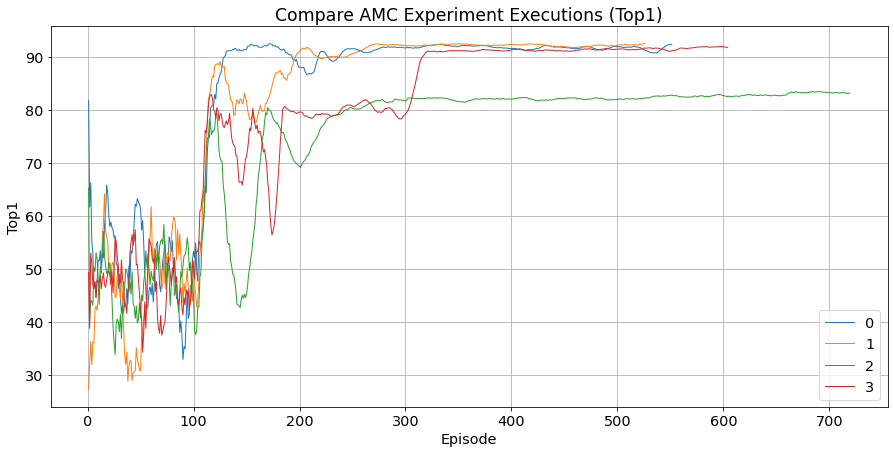

In [4]:
plot_experiment_comparison(df_list)

Now let's train some networks to convergence.  We look at all of the networks that were progressively discovered as "best" networks during AMC's search.  Note that these are **not** the best scoring discovered-networks.

Fine-tune for 60 epochs (using 16 processes): **notice the large LR**.

    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/resnet20-ddpg-private/2019.07.30-015225 --arch=resnet20_cifar --lr=0.1 --vs=0 -p=50 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16

* Bubbles represent discovered networks
* Bubble sizes represent the relative number of FLOPs in each network
* Darker networks were discovered later in the search process 

Best network: 88.03
Pearson: 0.785
   exp  search_top1   top1                                         name
7    0        91.60  88.03  BEST_adc_episode_121_0.7_checkpoint.pth.tar
6    0        90.38  87.83  BEST_adc_episode_119_0.7_checkpoint.pth.tar
16   1        87.68  87.61  BEST_adc_episode_015_0.7_checkpoint.pth.tar
17   1        93.08  87.42  BEST_adc_episode_050_0.7_checkpoint.pth.tar
33   3        92.46  87.41  BEST_adc_episode_534_0.7_checkpoint.pth.tar
34


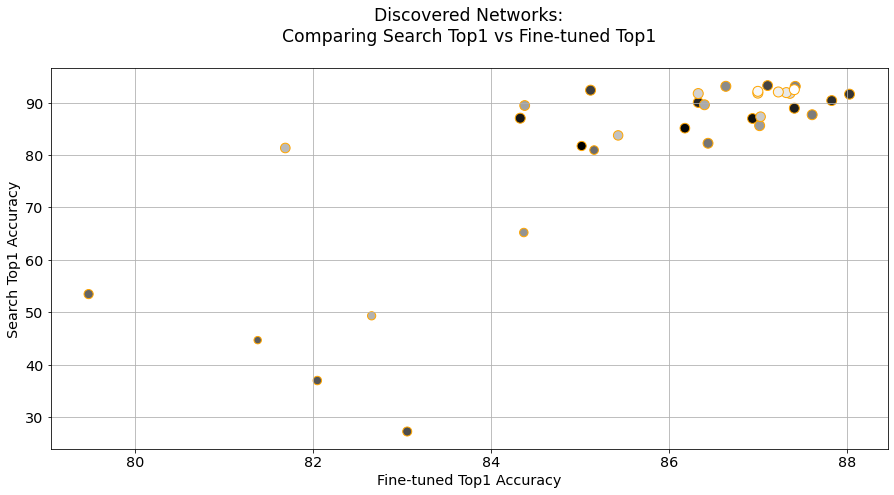

In [6]:
df_resnet20_ft2 = pd.read_csv(os.path.join(fpath, "ft_2epoch_results.csv"))

create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
shorten_dir_name(df_resnet20_ft2)
plot_networks(df_resnet20_ft2, edgecolors='orange')
print(len(df_resnet20_ft2.index))

Let's look at the same diagram from a different perspective.<br>
Remember, we ran our AMC experiment 4 times, and we fine-tuned networks discovered in each of these 4 experiments. Now let's separate these networks by color and observe how they cluster.

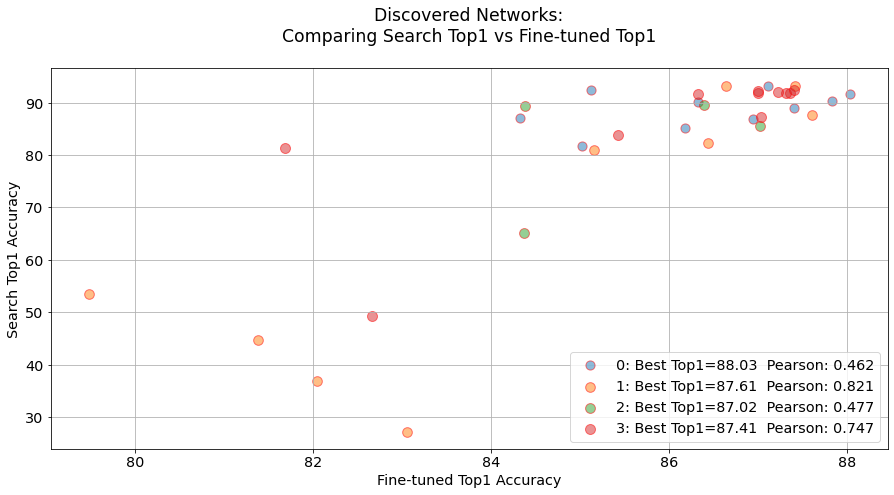

In [10]:
create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")

def plot_networks_by_experiment(df, edgecolors, create_figure=True):
    # Group by experiment directory
    df_grouped = df.groupby('exp')
    size = df.macs / max(df.macs) * 100
    legend = []
    for idx,(exp_dir, df_experiment) in enumerate(df_grouped):
        a = plt.scatter(df_experiment.top1, df_experiment.search_top1,s=size[idx],
                        edgecolors=edgecolors, alpha=0.5)
        p = pearsonr(df_experiment.top1, df_experiment.search_top1)[0]
        legend.append((a, "%s: Best Top1=%.2f  Pearson: %.3f" % (exp_dir, max(df_experiment.top1), p)))
    plots, labels = zip(*legend)
    plt.legend(plots, labels)
    
plot_networks_by_experiment(df_resnet20_ft2, edgecolors='red')#, create_figure=False)